# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import re
from transformers import pipeline
import tqdm as notebook_tqdm
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from collections import defaultdict
from collections import Counter
import ast
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

/Users/mollysiebecker/DATA 698/capstone-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mollysiebecker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mollysiebecker/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Load Data and Dictionaries

In [2]:
# import song data
df = pd.read_csv("https://raw.githubusercontent.com/mollysiebecker/data_698_capstone/refs/heads/main/songs_df.csv")

df.head()

,Rank,Year,Song,Artist,Lyrics,Instrumental,Detected_Language,Is_Non_English,Mixed_Language,Songwriters,Lyricists,Wikipedia_Genre
0,100,2024,Dance the Night,Dua Lipa,"Baby, you can find me under the lights\nDiamon...",False,en,False,NaN,"Caroline Ailin, Dua Lipa, Mark Ronson, Andrew ...",NaN,"Disco, disco-pop, synth-pop"
1,99,2024,Down Bad,Taylor Swift,Did you really beam me up\nIn a cloud of spark...,False,en,False,NaN,"Jack Antonoff, Taylor Swift",NaN,Synth-pop
2,98,2024,The Painter,Cody Johnson,She talks about the future like she's flippin'...,False,en,False,NaN,"Benjy Davis, Kat Higgins, Ryan Larkins",NaN,Country
3,97,2024,Fe!n,Travis Scott featuring Playboi Carti,\nJust come outside for the night (Yeah)\nTake...,False,en,False,NaN,"Playboi Carti, Travis Scott, Sheck Wes, Jahaan...",NaN,Rage
4,96,2024,Bulletproof,Nate Smith,"Usually, these ol' neon lights\nAre pretty goo...",False,en,False,NaN,"Ashley Gorley, Ben Johnson, Hunter Phelps",NaN,Country rock


In [3]:
df.tail()

,Rank,Year,Song,Artist,Lyrics,Instrumental,Detected_Language,Is_Non_English,Mixed_Language,Songwriters,Lyricists,Wikipedia_Genre
6025,5,1965,You've Lost That Lovin' Feelin',The Righteous Brothers,You never close your eyes anymore\nWhen I kiss...,False,en,False,NaN,"Barry Mann, Phil Spector, Cynthia Weil",NaN,"Pop, R&B, blue-eyed soul"
6026,4,1965,You Were on My Mind,We Five,When I woke up this mornin'\nYou were on my mi...,False,en,False,NaN,Sylvia Tyson,Sylvia Tyson,"Folk rock, [1]"
6027,3,1965,(I Can't Get No) Satisfaction,The Rolling Stones,I can't get no satisfaction\nI can't get no sa...,False,en,False,NaN,"Mick Jagger, Keith Richards",NaN,"Rock, [1], [2]"
6028,2,1965,I Can't Help Myself (Sugar Pie Honey Bunch),Four Tops,"Ooh\nSugar pie, honey bunch\nYou know that I l...",False,en,False,NaN,NaN,NaN,"Soul, pop"
6029,1,1965,Wooly Bully,Sam the Sham and the Pharaohs,"Uno, dos\nOne, two, tres, cuatro\nYes, Wooly B...",False,en,False,NaN,Sam the Sham,Sam the Sham,"Garage rock, [1], [2], rock and roll, [3]"


In [4]:
# import songwriter gender dictionary
df_songwriter_gender = pd.read_csv('https://raw.githubusercontent.com/mollysiebecker/data_698_capstone/refs/heads/main/songwriter_gender_lookup.csv')
dict_songwriter_gender = dict(zip(df_songwriter_gender['name'], df_songwriter_gender['gender']))


In [5]:
# import artist gender dictionary
df_artist_gender = pd.read_csv('https://raw.githubusercontent.com/mollysiebecker/data_698_capstone/refs/heads/main/artist_gender_lookup.csv')
dict_artist_gender = dict(zip(df_artist_gender['Artist'], df_artist_gender['Gender']))


# Manipulating Variables and Pre-Processing Lyrics

In [6]:
# drop instrumental, non-english, mixed language songs 
df = df[df['Instrumental'] != True]

df = df[df['Is_Non_English'] != True]

df = df[df['Mixed_Language'] != True]

# drop unnecessary columns
df = df.drop(['Instrumental', 'Is_Non_English', 'Mixed_Language', 'Detected_Language', 'Lyricists'], axis=1)

In [7]:
# function to normalize whitespace
def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

# apply to the 'Lyrics' column
df.loc[df['Lyrics'].notna(), 'Lyrics'] = df.loc[df['Lyrics'].notna(), 'Lyrics'].apply(normalize_whitespace)


In [8]:
# count number of songwriters
def count_items(string):
    if isinstance(string, str) and string.strip():
        items = string.split(",")
        cleaned_items = [item.strip() for item in items if item.strip()]
        return len(cleaned_items)
    else:
        return 0 

df['n_songwriters'] = df['Songwriters'].apply(count_items)


In [9]:
# map songwriter genders
def map_gender(string, lookup_dict):
    if isinstance(string, str) and string.strip():
        items = [item.strip() for item in string.split(",") if item.strip()]
        mapped = [lookup_dict.get(item, '') for item in items]
        return ",".join(mapped)
    else:
        return ''

df['songwriter_gender'] = df['Songwriters'].apply(lambda x: map_gender(x, dict_songwriter_gender))

In [10]:
# number of rows that contain "group" for songwriter gender
count_songwriter_group = df['songwriter_gender'].str.contains("group", na=False).sum()
print(count_songwriter_group)

25


In [11]:
# set n_songwriters to NA when genders contains "group"
# avoid counting groups as one writer

df.loc[df['songwriter_gender'].str.contains("group", na=False), 'n_songwriters'] = np.nan


In [12]:
# number of rows that contain "non-binary" for songwriter gender
count_songwriter_nonbinary = df['songwriter_gender'].str.contains("non-binary", na=False).sum()
print(count_songwriter_nonbinary)

46


In [13]:
# create n_women and n_men
df['n_women'] = df['songwriter_gender'].str.count(r'\bwoman\b').fillna(0).astype(int)
df['n_men'] = df['songwriter_gender'].str.count(r'\bman\b').fillna(0).astype(int)

# create pct_women and pct_men
df['pct_women'] = np.where(
    df['n_songwriters'] > 0,
    (df['n_women'] / df['n_songwriters']) * 100,
    np.nan  
)
df['pct_men'] = np.where(
    df['n_songwriters'] > 0,
    (df['n_men'] / df['n_songwriters']) * 100,
    np.nan  
)

In [15]:
# standardize various ways of saying "featuring"
def normalize_artist_string(s):
    if not isinstance(s, str):
        return ''
    return s.replace("featuring", ",").replace("feat.", ",").replace("ft.", ",")

df['Artist'] = df['Artist'].apply(normalize_artist_string)

# map artist gender
df['artist_gender'] = df['Artist'].apply(lambda x: map_gender(x, dict_artist_gender))

In [16]:
# add artist-songwriter combination
def get_combo(row):
    if row['artist_gender'] == 'man' and row['songwriter_gender'] == 'man':
        return 'male artist, male writer'
    elif row['artist_gender'] == 'man' and row['songwriter_gender'] == 'woman':
        return 'male artist, female writer'
    elif row['artist_gender'] == 'woman' and row['songwriter_gender'] == 'woman':
        return 'female artist, female writer'
    elif row['artist_gender'] == 'woman' and row['songwriter_gender'] == 'man':
        return 'female artist, male writer'
    else:
        return 'other or unknown'

df['artist_writer_combo'] = df.apply(get_combo, axis=1)

In [17]:
# create variable of individual tokens

def get_tokens(text):
    if isinstance(text, str):
        return [word for word in word_tokenize(text.lower()) if word.isalpha()]
    else:
        return []
        
df["tokens"] = df["Lyrics"].apply(get_tokens)

In [72]:
def remove_brackets(text):
    return re.sub(r'\[.*?\]', '', text)

df['Wikipedia_Genre'] = df['Wikipedia_Genre'].astype(str)


df['Wikipedia_Genre'] = df['Wikipedia_Genre'].apply(remove_brackets)

In [73]:
df.head()

,Rank,Year,Song,Artist,Lyrics,Songwriters,Wikipedia_Genre,n_songwriters,songwriter_gender,n_women,...,joy,love,anger,fear,surprise,primary_emotion,primary_emotion_score,emotion_word_count,total_words,emotion_words_per_100
0,100,2024,Dance the Night,Dua Lipa,"Baby, you can find me under the lights Diamond...","Caroline Ailin, Dua Lipa, Mark Ronson, Andrew ...","Disco, disco-pop, synth-pop",4.0,"woman,woman,man,man",2,...,0.997989,0.000502,0.000370,0.000352,0.000229,joy,0.997989,51,393,12.977099
1,99,2024,Down Bad,Taylor Swift,Did you really beam me up In a cloud of sparkl...,"Jack Antonoff, Taylor Swift",Synth-pop,2.0,"man,woman",1,...,0.001997,0.001275,0.964798,0.003667,0.000302,anger,0.964798,52,469,11.087420
2,98,2024,The Painter,Cody Johnson,She talks about the future like she's flippin'...,"Benjy Davis, Kat Higgins, Ryan Larkins",Country,3.0,"man,woman,man",1,...,0.346996,0.004338,0.597996,0.014207,0.001722,anger,0.597996,20,262,7.633588
3,97,2024,Fe!n,"Travis Scott , Playboi Carti",Just come outside for the night (Yeah) Take yo...,"Playboi Carti, Travis Scott, Sheck Wes, Jahaan...",Rage,4.0,"man,man,man,man",0,...,0.951564,0.002155,0.034731,0.004999,0.002998,joy,0.951564,28,572,4.895105
4,96,2024,Bulletproof,Nate Smith,"Usually, these ol' neon lights Are pretty good...","Ashley Gorley, Ben Johnson, Hunter Phelps",Country rock,3.0,"man,man,man",0,...,0.945268,0.010708,0.019300,0.004367,0.000874,joy,0.945268,30,289,10.380623


# Sentiment Analysis

In [19]:
classifier = pipeline(
    "text-classification",
    model="bhadresh-savani/distilbert-base-uncased-emotion",
    return_all_scores=True,
    truncation=True  
)

Device set to use mps:0
/Users/mollysiebecker/DATA 698/capstone-env/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [20]:
# apply classifier and extract scores
def get_emotion_scores(text):
    scores = classifier(text)[0] 
    return {d['label']: d['score'] for d in scores}

emotion_df = df['Lyrics'].apply(get_emotion_scores).apply(pd.Series)

# merge with original data
df = pd.concat([df, emotion_df], axis=1)

In [21]:
# assign primary emotion
df['primary_emotion'] = df[['sadness', 'love', 'joy', 'fear', 'anger', 'surprise']].idxmax(axis=1)
# assign primary emotion confidence score
df['primary_emotion_score'] = df[['sadness', 'love', 'joy', 'fear', 'anger', 'surprise']].max(axis=1)

In [22]:
# initialize NRC emotion dictionary
nrc_emotions = defaultdict(set)

# load the lexicon
with open("/Users/mollysiebecker/DATA 698/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", "r", encoding="utf-8") as f:
    for line in f:
        word, emotion, association = line.strip().split('\t')
        if association == '1':
            nrc_emotions[word].add(emotion)

# find rate of emotion words
def count_total_emotion_words(tokens, lexicon=nrc_emotions):
    return sum(1 for token in tokens if token in lexicon)

df['emotion_word_count'] = df['tokens'].apply(count_total_emotion_words)
df['total_words'] = df['tokens'].apply(len)
df['emotion_words_per_100'] = df['emotion_word_count'] / df['total_words'] * 100

# Exploratory Data Analysis

In [23]:
df.head()

,Rank,Year,Song,Artist,Lyrics,Songwriters,Wikipedia_Genre,n_songwriters,songwriter_gender,n_women,...,joy,love,anger,fear,surprise,primary_emotion,primary_emotion_score,emotion_word_count,total_words,emotion_words_per_100
0,100,2024,Dance the Night,Dua Lipa,"Baby, you can find me under the lights Diamond...","Caroline Ailin, Dua Lipa, Mark Ronson, Andrew ...","Disco, disco-pop, synth-pop",4.0,"woman,woman,man,man",2,...,0.997989,0.000502,0.000370,0.000352,0.000229,joy,0.997989,51,393,12.977099
1,99,2024,Down Bad,Taylor Swift,Did you really beam me up In a cloud of sparkl...,"Jack Antonoff, Taylor Swift",Synth-pop,2.0,"man,woman",1,...,0.001997,0.001275,0.964798,0.003667,0.000302,anger,0.964798,52,469,11.087420
2,98,2024,The Painter,Cody Johnson,She talks about the future like she's flippin'...,"Benjy Davis, Kat Higgins, Ryan Larkins",Country,3.0,"man,woman,man",1,...,0.346996,0.004338,0.597996,0.014207,0.001722,anger,0.597996,20,262,7.633588
3,97,2024,Fe!n,"Travis Scott , Playboi Carti",Just come outside for the night (Yeah) Take yo...,"Playboi Carti, Travis Scott, Sheck Wes, Jahaan...",Rage,4.0,"man,man,man,man",0,...,0.951564,0.002155,0.034731,0.004999,0.002998,joy,0.951564,28,572,4.895105
4,96,2024,Bulletproof,Nate Smith,"Usually, these ol' neon lights Are pretty good...","Ashley Gorley, Ben Johnson, Hunter Phelps",Country rock,3.0,"man,man,man",0,...,0.945268,0.010708,0.019300,0.004367,0.000874,joy,0.945268,30,289,10.380623


In [24]:
df.describe()

,Rank,Year,n_songwriters,n_women,n_men,pct_women,pct_men,sadness,joy,love,anger,fear,surprise,primary_emotion_score,emotion_word_count,total_words,emotion_words_per_100
count,5949.000000,5949.000000,5924.000000,5949.000000,5949.000000,4789.000000,4789.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000
mean,50.447806,1994.505799,2.167961,0.299042,1.779291,14.065397,83.266141,0.224857,0.434712,0.090163,0.183472,0.057246,0.009550,0.866071,37.802824,377.889225,10.185078
std,28.893716,17.212784,2.131736,0.615727,1.844730,26.551674,27.928486,0.369323,0.430121,0.248471,0.311096,0.191955,0.072755,0.170357,25.033568,192.663242,4.690712
min,1.000000,1965.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000150,0.000153,0.000119,0.000088,0.000090,0.000069,0.278330,0.000000,8.000000,0.000000
25%,25.000000,1980.000000,1.000000,0.000000,1.000000,0.000000,66.666667,0.002065,0.007095,0.000745,0.001241,0.000544,0.000294,0.769781,20.000000,245.000000,7.017544
50%,50.000000,1995.000000,2.000000,0.000000,1.000000,0.000000,100.000000,0.013859,0.252605,0.002575,0.012353,0.002199,0.000763,0.959142,32.000000,333.000000,9.477124
75%,76.000000,2009.000000,3.000000,0.000000,2.000000,20.000000,100.000000,0.247862,0.962960,0.010568,0.204802,0.010053,0.001667,0.994292,49.000000,464.000000,12.592593
max,100.000000,2024.000000,29.000000,5.000000,27.000000,100.000000,100.000000,0.999109,0.999017,0.995726,0.997875,0.997882,0.991226,0.999109,264.000000,2538.000000,42.105263


/Users/mollysiebecker/DATA 698/capstone-env/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


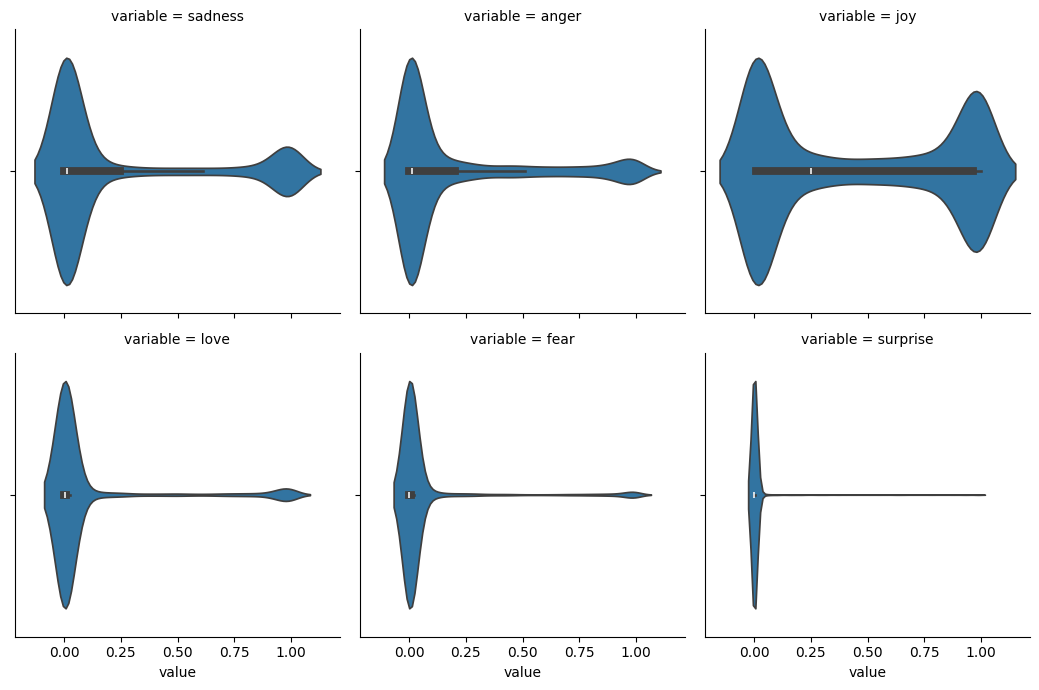

In [25]:
# visualize quantitative response variable distributions
df_quant_long = df[['sadness', 'anger', 'joy', 'love', 'fear', 'surprise']].melt(var_name='variable', value_name='value')

g = sns.FacetGrid(df_quant_long, col='variable', col_wrap=3, height=3.5)
g.map(sns.violinplot, 'value')
plt.tight_layout()
plt.show()

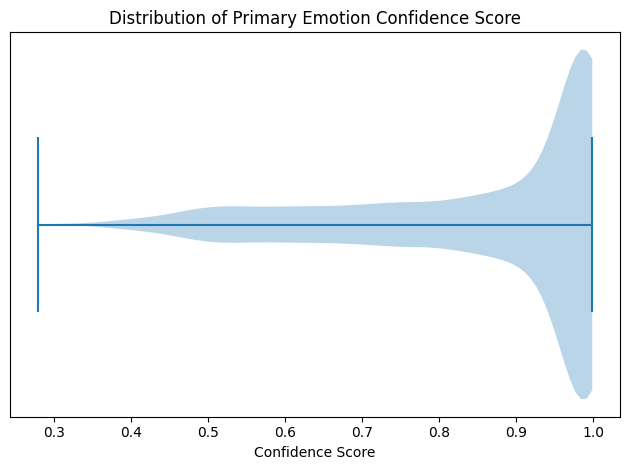

In [26]:
plt.violinplot(df['primary_emotion_score'], orientation='horizontal')
plt.title('Distribution of Primary Emotion Confidence Score')
plt.xlabel('Confidence Score')
plt.yticks([])           
plt.tick_params(axis='y', length=0)  
plt.tight_layout()
plt.show()

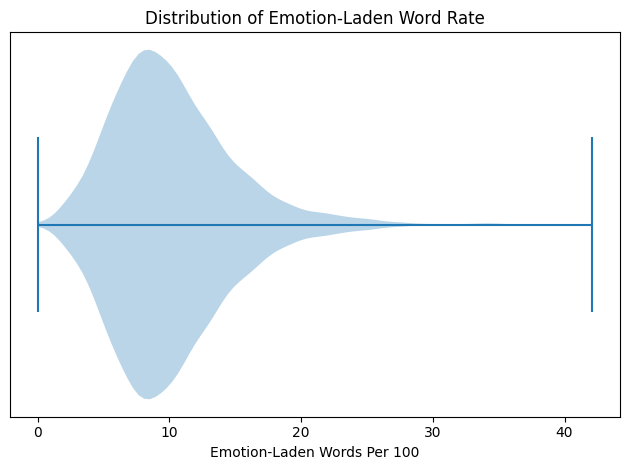

In [27]:
plt.violinplot(df['emotion_words_per_100'], orientation='horizontal')
plt.title('Distribution of Emotion-Laden Word Rate')
plt.xlabel('Emotion-Laden Words Per 100')
plt.yticks([])   
plt.tick_params(axis='y', length=0)
plt.tight_layout()
plt.show()

/var/folders/1v/5j_tx2md59j_pnk_h08c70nc0000gn/T/ipykernel_31619/4033048355.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


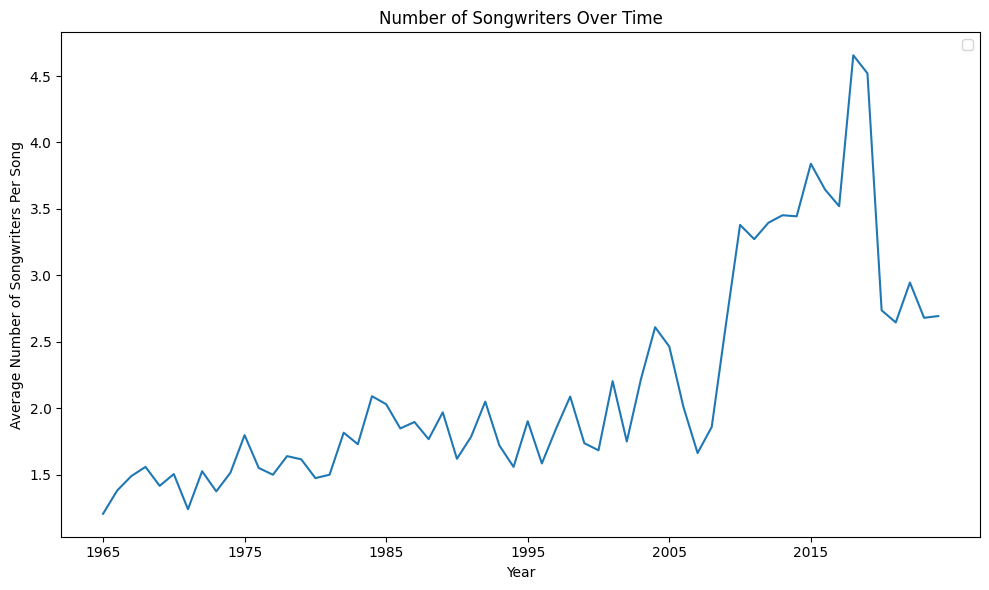

In [28]:
# visualize number of songwriters over time
df_avg_songwriters_by_year = df.groupby('Year')[['n_songwriters']].mean().reset_index()

plt.figure(figsize=(10, 6))

plt.plot(df_avg_songwriters_by_year['Year'], df_avg_songwriters_by_year['n_songwriters'])

plt.title('Number of Songwriters Over Time')
plt.xlabel('Year')
plt.ylabel('Average Number of Songwriters Per Song')
plt.grid(False)
plt.xticks(range(1965, 2025, 10))
plt.legend()
plt.tight_layout()
plt.show()

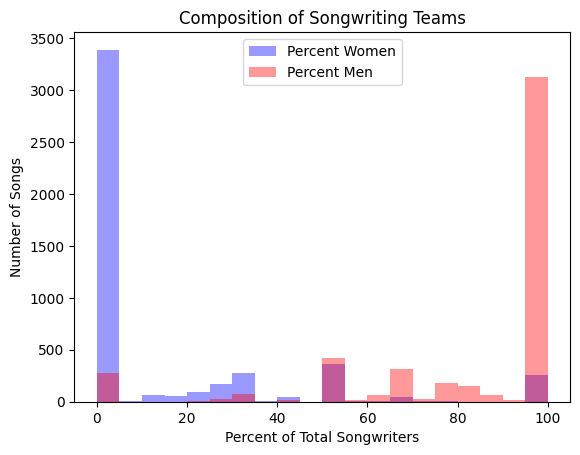

In [29]:
# visualize relative composition of songwriting teams
plt.hist(df['pct_women'], bins=20, alpha=0.4, label='Percent Women', color='blue')
plt.hist(df['pct_men'], bins=20, alpha=0.4, label='Percent Men', color='red')
plt.title('Composition of Songwriting Teams')
plt.xlabel('Percent of Total Songwriters')
plt.ylabel('Number of Songs')
plt.legend()
plt.grid(False)
plt.show()

# Significance Tests

In [30]:
# drop duplicate songs that charted in multiple years
df_unique_songs = df.drop(columns=["Year", "Rank", "tokens"]).drop_duplicates()

# songs with one songwriter
df_one_songwriter = df_unique_songs[
    (df_unique_songs['n_songwriters']==1) &
    (df_unique_songs['songwriter_gender'] != 'unknown')
    ]

# songs with one artist
df_one_artist = df_unique_songs[
    (df_unique_songs['artist_gender'] == 'man') |
    (df_unique_songs['artist_gender'] == 'woman') |
    (df_unique_songs['artist_gender'] == 'non-binary')
]

# songs with one artist and one songwriter
df_one_artist_one_writer = df_unique_songs[
    (df_unique_songs['n_songwriters']==1) &
    (df_unique_songs['songwriter_gender'] != 'unknown') &
    ((df_unique_songs['artist_gender'] == 'man') |
    (df_unique_songs['artist_gender'] == 'woman') |
    (df_unique_songs['artist_gender'] == 'non-binary'))
]

## Categorical & Quantitative Variable

In [31]:
df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'man'].describe()

,n_songwriters,n_women,n_men,pct_women,pct_men,sadness,joy,love,anger,fear,surprise,primary_emotion_score,emotion_word_count,total_words,emotion_words_per_100
count,1353.0,1353.0,1353.0,1353.0,1353.0,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000
mean,1.0,0.0,1.0,0.0,100.0,0.235312,0.422002,0.094052,0.170678,0.067598,0.010357,0.869377,28.894309,294.048041,10.028626
std,0.0,0.0,0.0,0.0,0.0,0.375880,0.432744,0.258375,0.301095,0.210468,0.074095,0.170218,18.097408,133.664985,4.651866
min,1.0,0.0,1.0,0.0,100.0,0.000192,0.000193,0.000126,0.000111,0.000099,0.000091,0.313143,0.000000,8.000000,0.000000
25%,1.0,0.0,1.0,0.0,100.0,0.001886,0.005273,0.000711,0.001108,0.000527,0.000292,0.773019,16.000000,205.000000,6.782334
50%,1.0,0.0,1.0,0.0,100.0,0.012840,0.191860,0.002360,0.009692,0.002119,0.000736,0.961831,25.000000,268.000000,9.271523
75%,1.0,0.0,1.0,0.0,100.0,0.336710,0.963011,0.009952,0.165268,0.011279,0.001501,0.994804,37.000000,350.000000,12.549020
max,1.0,0.0,1.0,0.0,100.0,0.999051,0.998976,0.995413,0.997810,0.997882,0.990204,0.999051,143.000000,1408.000000,36.574074


In [32]:
df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'woman'].describe()

,n_songwriters,n_women,n_men,pct_women,pct_men,sadness,joy,love,anger,fear,surprise,primary_emotion_score,emotion_word_count,total_words,emotion_words_per_100
count,205.0,205.0,205.0,205.0,205.0,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,1.0,1.0,0.0,100.0,0.0,0.247655,0.438540,0.089274,0.137923,0.062394,0.024213,0.873511,31.019512,305.931707,10.109713
std,0.0,0.0,0.0,0.0,0.0,0.387424,0.431245,0.243722,0.281126,0.196198,0.125853,0.157582,20.429448,125.568102,4.268670
min,1.0,1.0,0.0,100.0,0.0,0.000256,0.000215,0.000126,0.000119,0.000090,0.000093,0.401216,4.000000,90.000000,1.851852
25%,1.0,1.0,0.0,100.0,0.0,0.002126,0.008841,0.000943,0.001111,0.000488,0.000258,0.800270,19.000000,226.000000,7.352941
50%,1.0,1.0,0.0,100.0,0.0,0.015628,0.229362,0.002366,0.008396,0.002318,0.000734,0.960319,27.000000,279.000000,9.448819
75%,1.0,1.0,0.0,100.0,0.0,0.447083,0.971364,0.011427,0.074719,0.012978,0.001676,0.994537,39.000000,359.000000,11.733333
max,1.0,1.0,0.0,100.0,0.0,0.999069,0.998953,0.994855,0.997181,0.995492,0.926389,0.999069,184.000000,932.000000,26.025460


In [33]:
stat, p = mannwhitneyu(df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'man']['emotion_words_per_100'], df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'woman']['emotion_words_per_100'], alternative='two-sided')
print(stat, p)

135253.5 0.5679015902702162


In [34]:
stat, p = mannwhitneyu(df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'man']['primary_emotion_score'], df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'woman']['primary_emotion_score'], alternative='two-sided')
print(stat, p)

139701.0 0.8653358811717445


In [35]:
stat, p = mannwhitneyu(df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'man']['anger'], df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'woman']['anger'], alternative='two-sided')
print(stat, p)

146126.0 0.2150091135150678


In [36]:
stat, p = mannwhitneyu(df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'man']['sadness'], df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'woman']['sadness'], alternative='two-sided')
print(stat, p)

134381.0 0.47368777402040074


In [37]:
stat, p = mannwhitneyu(df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'man']['joy'], df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'woman']['joy'], alternative='two-sided')
print(stat, p)

134307.0 0.46611227573019154


In [38]:
stat, p = mannwhitneyu(df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'man']['love'], df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'woman']['love'], alternative='two-sided')
print(stat, p)

135378.0 0.5820421363872683


In [39]:
stat, p = mannwhitneyu(df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'man']['fear'], df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'woman']['fear'], alternative='two-sided')
print(stat, p)

139253.0 0.9243507863279866


In [40]:
stat, p = mannwhitneyu(df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'man']['surprise'], df_one_songwriter[df_one_songwriter['songwriter_gender'] == 'woman']['surprise'], alternative='two-sided')
print(stat, p)

140924.0 0.708908797853331


In [41]:
df_one_artist[df_one_artist['artist_gender'] == 'man'].describe()

,n_songwriters,n_women,n_men,pct_women,pct_men,sadness,joy,love,anger,fear,surprise,primary_emotion_score,emotion_word_count,total_words,emotion_words_per_100
count,1641.000000,1642.000000,1642.000000,1329.000000,1329.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000
mean,1.828763,0.088916,1.672351,3.839406,94.044040,0.227988,0.432757,0.080708,0.193828,0.055826,0.008894,0.863077,35.123021,358.746041,9.996728
std,1.903924,0.315184,1.695915,13.954065,16.314662,0.369420,0.430191,0.234277,0.315982,0.189031,0.069839,0.172481,22.503722,179.253056,4.510081
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000193,0.000178,0.000131,0.000104,0.000098,0.000087,0.313143,0.000000,8.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,100.000000,0.002193,0.006940,0.000741,0.001325,0.000566,0.000300,0.762475,19.000000,233.000000,6.962813
50%,1.000000,0.000000,1.000000,0.000000,100.000000,0.015457,0.248257,0.002592,0.013854,0.002394,0.000767,0.955226,30.000000,312.500000,9.350121
75%,3.000000,0.000000,2.000000,0.000000,100.000000,0.267349,0.960180,0.010363,0.245549,0.010224,0.001583,0.993915,45.000000,433.750000,12.301996
max,29.000000,2.000000,27.000000,100.000000,100.000000,0.999109,0.998982,0.995011,0.997810,0.997765,0.990204,0.999109,176.000000,1408.000000,42.105263


In [42]:
df_one_artist[df_one_artist['artist_gender'] == 'woman'].describe()

,n_songwriters,n_women,n_men,pct_women,pct_men,sadness,joy,love,anger,fear,surprise,primary_emotion_score,emotion_word_count,total_words,emotion_words_per_100
count,979.000000,980.000000,980.000000,862.000000,862.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
mean,2.219612,0.726531,1.421429,36.919802,61.128250,0.252019,0.435069,0.093920,0.150464,0.057274,0.011254,0.878259,37.227551,360.150000,10.413639
std,1.807670,0.729301,1.400770,34.797560,35.239774,0.388635,0.437031,0.255229,0.292051,0.193737,0.080931,0.166423,22.964427,138.441371,4.799592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000199,0.000153,0.000126,0.000119,0.000090,0.000069,0.292230,3.000000,90.000000,1.398601
25%,1.000000,0.000000,0.000000,0.000000,50.000000,0.001808,0.005203,0.000698,0.000992,0.000480,0.000254,0.809156,22.000000,265.000000,7.137329
50%,2.000000,1.000000,1.000000,33.333333,66.666667,0.011586,0.221074,0.002363,0.008095,0.001633,0.000659,0.973619,32.000000,337.500000,9.707889
75%,3.000000,1.000000,2.000000,50.000000,100.000000,0.439640,0.973925,0.009984,0.088204,0.008342,0.001475,0.995203,46.000000,436.000000,12.850851
max,17.000000,5.000000,14.000000,100.000000,100.000000,0.999069,0.998953,0.995726,0.997860,0.997882,0.990895,0.999069,181.000000,932.000000,34.375000


In [43]:
stat, p = mannwhitneyu(df_one_artist[df_one_artist['artist_gender'] == 'man']['emotion_words_per_100'], df_one_artist[df_one_artist['artist_gender'] == 'woman']['emotion_words_per_100'], alternative='two-sided')
print(stat, p)

768974.5 0.057634636242483356


In [44]:
stat, p = mannwhitneyu(df_one_artist[df_one_artist['artist_gender'] == 'man']['primary_emotion_score'], df_one_artist[df_one_artist['artist_gender'] == 'woman']['primary_emotion_score'], alternative='two-sided')
print(stat, p)

752973.0 0.005929232627145364


In [45]:
stat, p = mannwhitneyu(df_one_artist[df_one_artist['artist_gender'] == 'man']['anger'], df_one_artist[df_one_artist['artist_gender'] == 'woman']['anger'], alternative='two-sided')
print(stat, p)

879195.0 6.936280732374187e-05


In [46]:
stat, p = mannwhitneyu(df_one_artist[df_one_artist['artist_gender'] == 'man']['love'], df_one_artist[df_one_artist['artist_gender'] == 'woman']['love'], alternative='two-sided')
print(stat, p)

820081.0 0.408526222719949


In [47]:
stat, p = mannwhitneyu(df_one_artist[df_one_artist['artist_gender'] == 'man']['sadness'], df_one_artist[df_one_artist['artist_gender'] == 'woman']['sadness'], alternative='two-sided')
print(stat, p)

815979.5 0.5433220583595451


In [48]:
stat, p = mannwhitneyu(df_one_artist[df_one_artist['artist_gender'] == 'man']['joy'], df_one_artist[df_one_artist['artist_gender'] == 'woman']['joy'], alternative='two-sided')
print(stat, p)

807452.5 0.8782913045959813


In [49]:
stat, p = mannwhitneyu(df_one_artist[df_one_artist['artist_gender'] == 'man']['fear'], df_one_artist[df_one_artist['artist_gender'] == 'woman']['fear'], alternative='two-sided')
print(stat, p)

854383.0 0.007919566785553427


In [50]:
stat, p = mannwhitneyu(df_one_artist[df_one_artist['artist_gender'] == 'man']['surprise'], df_one_artist[df_one_artist['artist_gender'] == 'woman']['surprise'], alternative='two-sided')
print(stat, p)

848844.5 0.018266766695743803


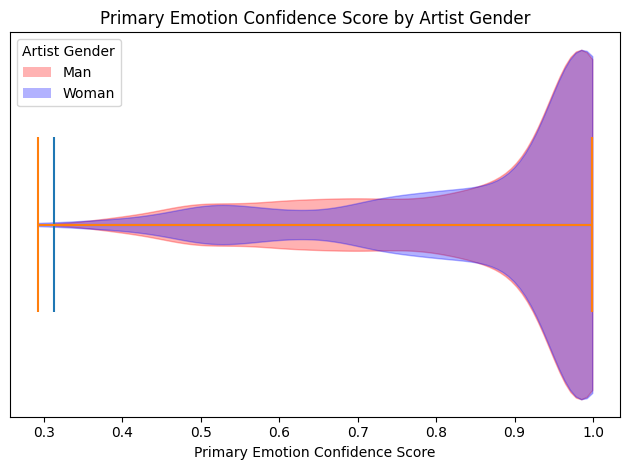

In [51]:
# visualize distributions with significant differences
# primary emotion score
fig, ax = plt.subplots()
vp_man = ax.violinplot(df_one_artist[df_one_artist['artist_gender']=='man']['primary_emotion_score'], positions=[1], vert=False, widths=0.7)
vp_woman = ax.violinplot(df_one_artist[df_one_artist['artist_gender']=='woman']['primary_emotion_score'], positions=[1], vert=False, widths=0.7)


for pc in vp_man['bodies']:
    pc.set_facecolor('red')
    pc.set_alpha(0.3)
    pc.set_edgecolor('red')

for pc in vp_woman['bodies']:
    pc.set_facecolor('blue')
    pc.set_alpha(0.3)
    pc.set_edgecolor('blue')

legend_patches = [
    Patch(facecolor='red', alpha=0.3, label='Man'),
    Patch(facecolor='blue', alpha=0.3, label='Woman')
]
ax.legend(handles=legend_patches, title='Artist Gender')

ax.set_xlabel('Primary Emotion Confidence Score')
ax.set_title('Primary Emotion Confidence Score by Artist Gender')
plt.yticks([])           
plt.tick_params(axis='y', length=0)  
plt.tight_layout()
plt.show()

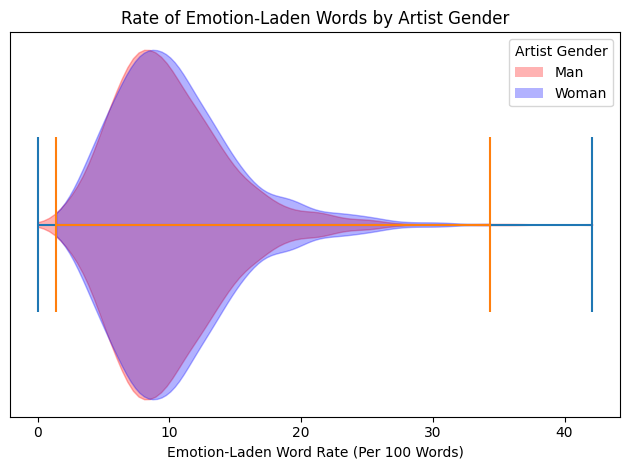

In [52]:
# emotion word rate
fig, ax = plt.subplots()
vp_man = ax.violinplot(df_one_artist[df_one_artist['artist_gender']=='man']['emotion_words_per_100'], positions=[1], vert=False, widths=0.7)
vp_woman = ax.violinplot(df_one_artist[df_one_artist['artist_gender']=='woman']['emotion_words_per_100'], positions=[1], vert=False,widths=0.7)


for pc in vp_man['bodies']:
    pc.set_facecolor('red')
    pc.set_alpha(0.3)
    pc.set_edgecolor('red')

for pc in vp_woman['bodies']:
    pc.set_facecolor('blue')
    pc.set_alpha(0.3)
    pc.set_edgecolor('blue')

legend_patches = [
    Patch(facecolor='red', alpha=0.3, label='Man'),
    Patch(facecolor='blue', alpha=0.3, label='Woman')
]
ax.legend(handles=legend_patches, title='Artist Gender')

ax.set_xlabel('Emotion-Laden Word Rate (Per 100 Words)')
ax.set_title('Rate of Emotion-Laden Words by Artist Gender')
plt.yticks([])           
plt.tick_params(axis='y', length=0)  
plt.tight_layout()
plt.show()

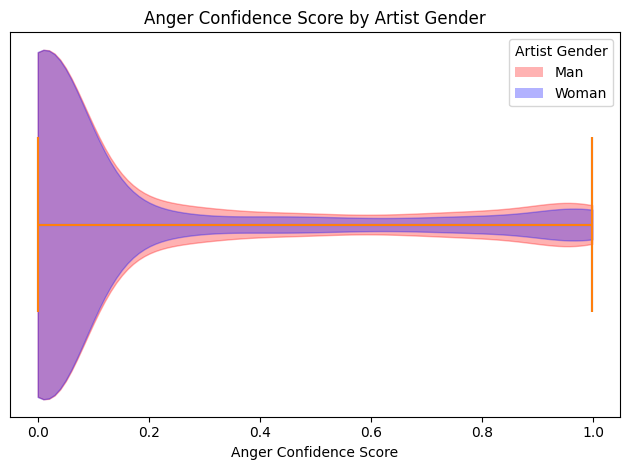

In [53]:
# anger confidence score
fig, ax = plt.subplots()
vp_man = ax.violinplot(df_one_artist[df_one_artist['artist_gender']=='man']['anger'], positions=[1], vert=False, widths=0.7)
vp_woman = ax.violinplot(df_one_artist[df_one_artist['artist_gender']=='woman']['anger'], positions=[1], vert=False, widths=0.7)


for pc in vp_man['bodies']:
    pc.set_facecolor('red')
    pc.set_alpha(0.3)
    pc.set_edgecolor('red')

for pc in vp_woman['bodies']:
    pc.set_facecolor('blue')
    pc.set_alpha(0.3)
    pc.set_edgecolor('blue')

legend_patches = [
    Patch(facecolor='red', alpha=0.3, label='Man'),
    Patch(facecolor='blue', alpha=0.3, label='Woman')
]
ax.legend(handles=legend_patches, title='Artist Gender')

ax.set_xlabel('Anger Confidence Score')
ax.set_title('Anger Confidence Score by Artist Gender')
plt.yticks([])           
plt.tick_params(axis='y', length=0)  
plt.tight_layout()
plt.show()

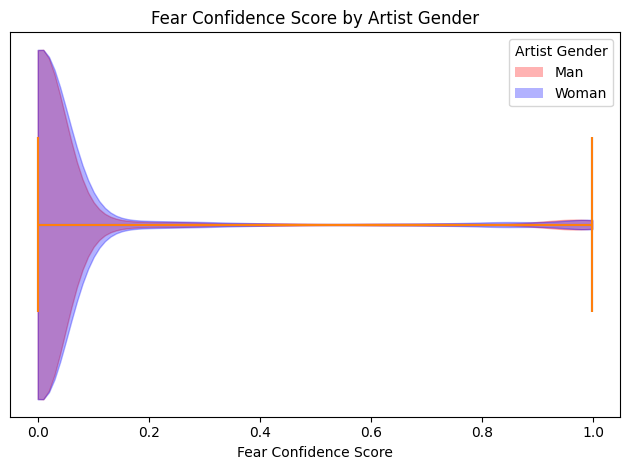

In [54]:
# fear confidence score
fig, ax = plt.subplots()
vp_man = ax.violinplot(df_one_artist[df_one_artist['artist_gender']=='man']['fear'], positions=[1], vert=False, widths=0.7)
vp_woman = ax.violinplot(df_one_artist[df_one_artist['artist_gender']=='woman']['fear'], positions=[1], vert=False, widths=0.7)


for pc in vp_man['bodies']:
    pc.set_facecolor('red')
    pc.set_alpha(0.3)
    pc.set_edgecolor('red')

for pc in vp_woman['bodies']:
    pc.set_facecolor('blue')
    pc.set_alpha(0.3)
    pc.set_edgecolor('blue')

legend_patches = [
    Patch(facecolor='red', alpha=0.3, label='Man'),
    Patch(facecolor='blue', alpha=0.3, label='Woman')
]
ax.legend(handles=legend_patches, title='Artist Gender')

ax.set_xlabel('Fear Confidence Score')
ax.set_title('Fear Confidence Score by Artist Gender')
plt.yticks([])           
plt.tick_params(axis='y', length=0)  
plt.tight_layout()
plt.show()

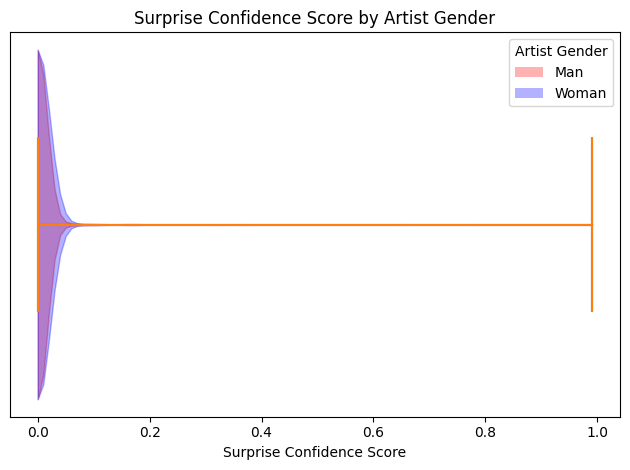

In [55]:
# surprise confidence score
fig, ax = plt.subplots()
vp_man = ax.violinplot(df_one_artist[df_one_artist['artist_gender']=='man']['surprise'], positions=[1], vert=False, widths=0.7)
vp_woman = ax.violinplot(df_one_artist[df_one_artist['artist_gender']=='woman']['surprise'], positions=[1], vert=False, widths=0.7)


for pc in vp_man['bodies']:
    pc.set_facecolor('red')
    pc.set_alpha(0.3)
    pc.set_edgecolor('red')

for pc in vp_woman['bodies']:
    pc.set_facecolor('blue')
    pc.set_alpha(0.3)
    pc.set_edgecolor('blue')

legend_patches = [
    Patch(facecolor='red', alpha=0.3, label='Man'),
    Patch(facecolor='blue', alpha=0.3, label='Woman')
]
ax.legend(handles=legend_patches, title='Artist Gender')

ax.set_xlabel('Surprise Confidence Score')
ax.set_title('Surprise Confidence Score by Artist Gender')
plt.yticks([])           
plt.tick_params(axis='y', length=0)  
plt.tight_layout()
plt.show()

## Two Categorical Variables

In [56]:
# build contingency table
contingency_songwriter_gender = pd.crosstab([df_one_songwriter['songwriter_gender']], df_one_songwriter['primary_emotion'])
print(contingency_songwriter_gender)

primary_emotion    anger  fear  joy  love  sadness  surprise
songwriter_gender                                           
man                  225    86  594   122      317         9
woman                 29    10   90    18       52         6


In [57]:
# run chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_songwriter_gender)

print("\nChi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
print("Expected frequencies:\n", expected)


Chi-square statistic: 11.055879535752783
Degrees of freedom: 5
P-value: 0.050283244517936164
Expected frequencies:
 [[220.57894737  83.36842105 594.         121.57894737 320.44736842
   13.02631579]
 [ 33.42105263  12.63157895  90.          18.42105263  48.55263158
    1.97368421]]


In [58]:
# convert to df
expected_df_songwriter = pd.DataFrame(expected, index=contingency_songwriter_gender.index, columns=contingency_songwriter_gender.columns)

# calculate standardized residuals
residuals_songwriter = (contingency_songwriter_gender - expected_df_songwriter) / np.sqrt(expected_df_songwriter)
print("Standardized Residuals:\n", residuals_songwriter)

Standardized Residuals:
 primary_emotion       anger      fear  joy      love   sadness  surprise
songwriter_gender                                                       
man                0.297676  0.288214  0.0  0.038186 -0.192579 -1.115571
woman             -0.764743 -0.740436  0.0 -0.098102  0.494745  2.865953


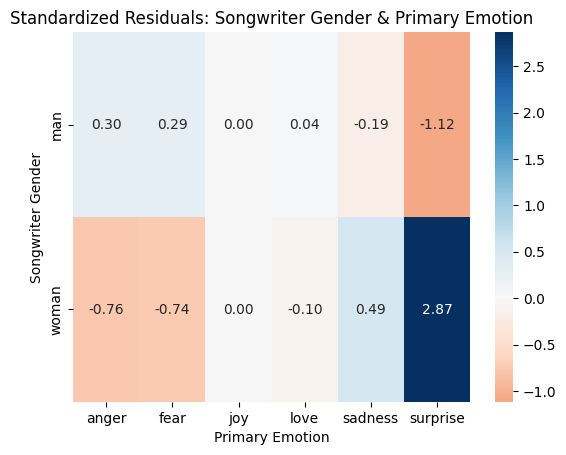

In [59]:
# plot heatmap
sns.heatmap(residuals_songwriter, annot=True, fmt=".2f", cmap="RdBu", center=0)
plt.title('Standardized Residuals: Songwriter Gender & Primary Emotion')
plt.xlabel('Primary Emotion')
plt.ylabel('Songwriter Gender')
plt.show()

In [60]:
# build contingency table
contingency_artist_gender = pd.crosstab([df_one_artist['artist_gender']], df_one_artist['primary_emotion'])
print(contingency_artist_gender)

primary_emotion  anger  fear  joy  love  sadness  surprise
artist_gender                                             
man                316    83  740   126      367        10
non-binary           5     6    7     0        8         0
woman              149    50  431    88      250        12


In [61]:
# remove non-binary category due to multiple counts lower than 5
contingency_artist_gender = pd.crosstab([df_one_artist[df_one_artist['artist_gender'] != 'non-binary']['artist_gender']], df_one_artist[df_one_artist['artist_gender'] != 'non-binary']['primary_emotion'])
print(contingency_artist_gender)

primary_emotion  anger  fear  joy  love  sadness  surprise
artist_gender                                             
man                316    83  740   126      367        10
woman              149    50  431    88      250        12


In [62]:
# run chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_artist_gender)

print("\nChi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
print("Expected frequencies:\n", expected)


Chi-square statistic: 12.47211254911163
Degrees of freedom: 5
P-value: 0.028861194847748798
Expected frequencies:
 [[291.201373    83.28985507 733.32646834 134.01525553 386.38977879
   13.77726926]
 [173.798627    49.71014493 437.67353166  79.98474447 230.61022121
    8.22273074]]


In [63]:
# convert to df
expected_df_artist = pd.DataFrame(expected, index=contingency_artist_gender.index, columns=contingency_artist_gender.columns)

# calculate standardized residuals
residuals_artist = (contingency_artist_gender - expected_df_artist) / np.sqrt(expected_df_artist)
print("Standardized Residuals:\n", residuals_artist)

Standardized Residuals:
 primary_emotion     anger      fear       joy      love   sadness  surprise
artist_gender                                                              
man              1.453219 -0.031760  0.246438 -0.692373 -0.986416 -1.017645
woman           -1.881068  0.041111 -0.318993  0.896218  1.276831  1.317255


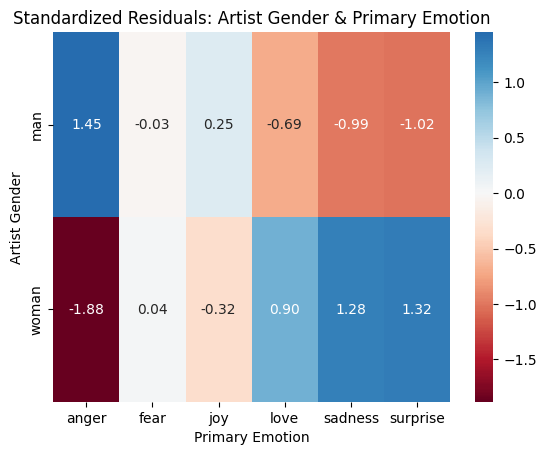

In [64]:
# plot heatmap
sns.heatmap(residuals_artist, annot=True, fmt=".2f", cmap="RdBu", center=0)
plt.title('Standardized Residuals: Artist Gender & Primary Emotion')
plt.xlabel('Primary Emotion')
plt.ylabel('Artist Gender')
plt.show()

In [65]:
# build contingency table
contingency_combo = pd.crosstab([df_one_artist_one_writer['artist_writer_combo']], df_one_artist_one_writer['primary_emotion'])
print(contingency_combo)

primary_emotion               anger  fear  joy  love  sadness  surprise
artist_writer_combo                                                    
female artist, female writer     14     4   60    11       36         3
female artist, male writer       18    13   57    16       35         1
male artist, female writer        2     0    7     2        1         0
male artist, male writer        107    34  263    45      123         6


In [66]:
# remove levels with multiple counts lower than 5
df_one_artist_one_writer_filtered = df_one_artist_one_writer[(df_one_artist_one_writer['artist_writer_combo'] != 'male artist, female writer') & (df_one_artist_one_writer['primary_emotion'] != 'fear') & (df_one_artist_one_writer['primary_emotion'] != 'surprise')]

In [67]:
# build contingency table
contingency_combo = pd.crosstab([df_one_artist_one_writer_filtered['artist_writer_combo']], df_one_artist_one_writer_filtered['primary_emotion'])
print(contingency_combo)

primary_emotion               anger  joy  love  sadness
artist_writer_combo                                    
female artist, female writer     14   60    11       36
female artist, male writer       18   57    16       35
male artist, male writer        107  263    45      123


In [68]:
# run chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_combo)

print("\nChi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
print("Expected frequencies:\n", expected)


Chi-square statistic: 9.733311958253747
Degrees of freedom: 6
P-value: 0.13634145938339598
Expected frequencies:
 [[ 21.42547771  58.57324841  11.09808917  29.90318471]
 [ 22.31082803  60.99363057  11.5566879   31.1388535 ]
 [ 95.26369427 260.43312102  49.34522293 132.95796178]]


In [69]:
# convert to df
expected_df_combo = pd.DataFrame(expected, index=contingency_combo.index, columns=contingency_combo.columns)

# calculate standardized residuals
residuals_combo = (contingency_combo - expected_df_combo) / np.sqrt(expected_df_combo)
print("Standardized Residuals:\n", residuals_combo)

Standardized Residuals:
 primary_emotion                  anger       joy      love   sadness
artist_writer_combo                                                 
female artist, female writer -1.604202  0.186423 -0.029444  1.114922
female artist, male writer   -0.912647 -0.511359  1.307044  0.691934
male artist, male writer      1.202452  0.159059 -0.618571 -0.863601


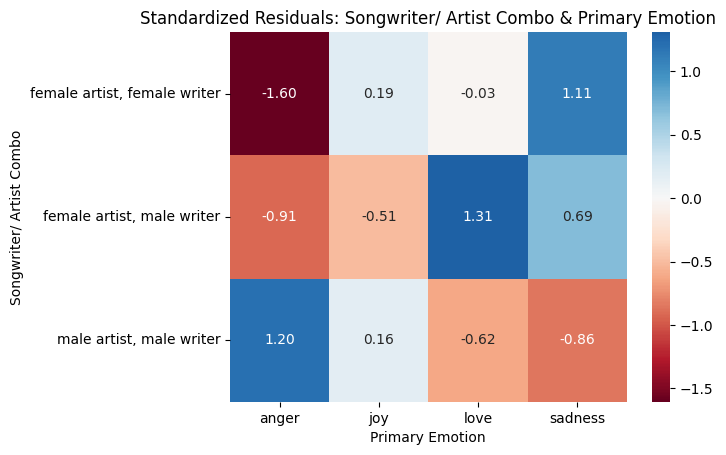

In [70]:
# plot heatmap
sns.heatmap(residuals_combo, annot=True, fmt=".2f", cmap="RdBu", center=0)
plt.title('Standardized Residuals: Songwriter/ Artist Combo & Primary Emotion')
plt.xlabel('Primary Emotion')
plt.ylabel('Songwriter/ Artist Combo')
plt.show()